In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models, utils
from tqdm import tqdm

# Import to turn of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [5]:
# Deprecated function, for now

# Function to minimize the number of possible outliers in dataset
# def treated_dataset(dataset):
#     print("Dataset length before treatment: ", len(dataset))
#     # print("List of removed samples: ")
#     for i, image_tuple in enumerate(dataset):
#         image = image_tuple[0].permute(1, 2, 0)
#         total_non_zero = np.count_nonzero(image)
#         total_pixels = 256*256*3
#         percentage_non_zero = (total_non_zero / total_pixels) * 100
#         sample_name = dataset.samples[i][0]
#         # Only getting string after "Data\"
#         sample_name = sample_name[5:]
#         if percentage_non_zero < 40:
#             # print(f"Sample name: {sample_name} with a percentage of non-zero pixels: {round((total_non_zero / total_pixels) * 100, 2)}")
#             dataset.samples.remove(dataset.samples[i])
#             dataset.targets.remove(dataset.targets[i])
            
#     print("Dataset length after treatment: ", len(dataset))
#     print("Dataset treated successfully!")
    
#     return dataset

In [4]:
# Trasform for data augmentation
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, shear=15, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Importing the dataset
training = datasets.ImageFolder('Data/Training/', transform=transform)
testing = datasets.ImageFolder('Data/Testing/', transform=transforms.Compose([
                                    transforms.Resize((256,256)),transforms.ToTensor()]))

# Split the data into 0.8 training and 0.2 testing sets
train_size = int(0.8 * len(training))
test_size = len(training) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(training, [train_size, test_size])

# Make a validation set from the training set
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create a DataLoader for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(testing, batch_size=32, shuffle=True)

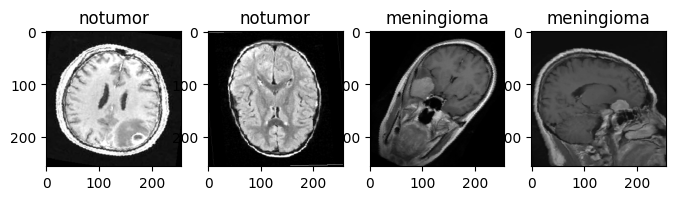

In [6]:
# Create a dictionary to map the labels to the brain tumor images
classes = training.classes

# Create a function to show a batch of images with labels
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(figsize=(8, 4), ncols=4)
    for i in range(4):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(classes[labels[i]])
    plt.show()

# Show a batch of images
show_batch_images(train_loader)

In [7]:
# Make a class to use a pretrained EfficientNet model for Image Classification
# the input size is 3x256x256
class EfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model._fc = nn.Linear(in_features=1280, out_features=num_classes, bias=True)
    def forward(self, x):
        return self.model(x)
    
# Create an instance of the EfficientNet class
model = EfficientNet(num_classes=4)

# Show model summary
model

# Move the model to the device
model.to(device)

# Create an optimizer and a loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

d:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# Create a function to train the model
def train(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=4)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_loss = running_loss / len(val_loader)
            val_acc = correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs

# Train the model for 5 epochs
train_losses, val_losses, train_accs, val_accs = train(model, optimizer, criterion, train_loader, val_loader, epochs=5)

In [9]:
# Create a function to train the model
def train(model, optimizer, criterion, train_loader, val_loader, epochs=100, early_stopping=None):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            # labels = torch.nn.functional.one_hot(labels, num_classes=4)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):
                images = images.to(device)
                # labels = torch.nn.functional.one_hot(labels, num_classes=4)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        print(f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, val_losses, train_accs, val_accs

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=3, verbose=True)

# Train the model with early stopping
train_losses, val_losses, train_accs, val_accs = train(model, optimizer, criterion, train_loader, val_loader, epochs=100, early_stopping=early_stopping)

  0%|          | 0/129 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 1/100
Train loss: 1.7565, Train acc: 0.6997
val loss: 0.2777, val acc: 0.9147
Validation loss decreased (inf --> 0.277729).  Saving model ...


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 2/100
Train loss: 0.3156, Train acc: 0.9032
val loss: 0.1464, val acc: 0.9409
Validation loss decreased (0.277729 --> 0.146448).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Epoch 3/100
Train loss: 0.2040, Train acc: 0.9324
val loss: 0.1070, val acc: 0.9672
Validation loss decreased (0.146448 --> 0.106960).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 4/100
Train loss: 0.1583, Train acc: 0.9429
val loss: 0.0768, val acc: 0.9781
Validation loss decreased (0.106960 --> 0.076816).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Epoch 5/100
Train loss: 0.1325, Train acc: 0.9516
val loss: 0.0763, val acc: 0.9781
Validation loss decreased (0.076816 --> 0.076290).  Saving model ...


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


Epoch 6/100
Train loss: 0.1107, Train acc: 0.9621
val loss: 0.0782, val acc: 0.9694
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 7/100
Train loss: 0.0982, Train acc: 0.9669
val loss: 0.0337, val acc: 0.9912
Validation loss decreased (0.076290 --> 0.033710).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 8/100
Train loss: 0.0834, Train acc: 0.9698
val loss: 0.0368, val acc: 0.9934
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 9/100
Train loss: 0.0737, Train acc: 0.9732
val loss: 0.0321, val acc: 0.9869
Validation loss decreased (0.033710 --> 0.032112).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 10/100
Train loss: 0.0671, Train acc: 0.9767
val loss: 0.0476, val acc: 0.9847
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 11/100
Train loss: 0.0590, Train acc: 0.9798
val loss: 0.0343, val acc: 0.9869
EarlyStopping counter: 2 out of 3


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Epoch 12/100
Train loss: 0.0601, Train acc: 0.9798
val loss: 0.0219, val acc: 0.9934
Validation loss decreased (0.032112 --> 0.021886).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 13/100
Train loss: 0.0455, Train acc: 0.9854
val loss: 0.0446, val acc: 0.9847
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 14/100
Train loss: 0.0547, Train acc: 0.9810
val loss: 0.0168, val acc: 0.9912
Validation loss decreased (0.021886 --> 0.016788).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 15/100
Train loss: 0.0399, Train acc: 0.9871
val loss: 0.0207, val acc: 0.9934
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Epoch 16/100
Train loss: 0.0371, Train acc: 0.9878
val loss: 0.0197, val acc: 0.9869
EarlyStopping counter: 2 out of 3


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]

Epoch 17/100
Train loss: 0.0355, Train acc: 0.9881
val loss: 0.0212, val acc: 0.9934
EarlyStopping counter: 3 out of 3
Early stopping


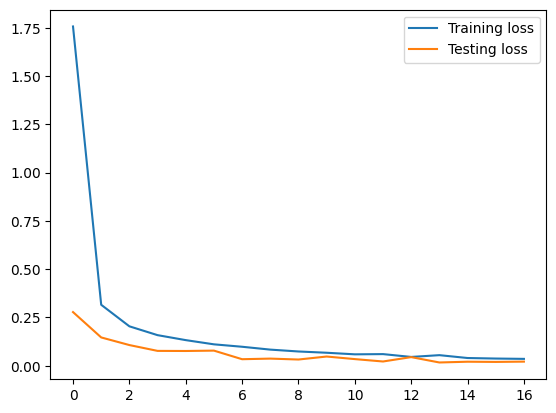

In [10]:
# Plot the training and testing losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Testing loss')
plt.legend()
plt.show()

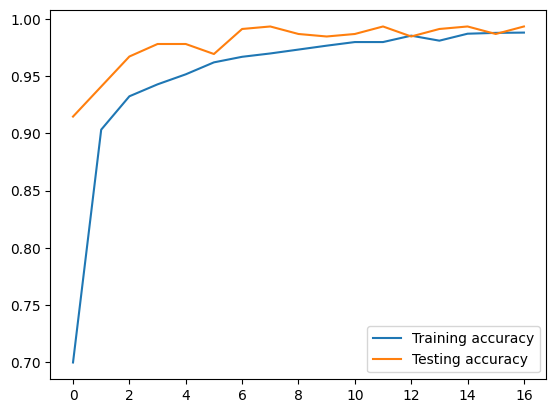

In [11]:
# Plot the training and testing accuracies
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Testing accuracy')
plt.legend()
plt.show()

In [25]:
# Get the best model from checkpoint
best_model = EfficientNet(num_classes=4)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

# Use the best model to make predictions on the test dataset
correct = 0
total = 0
images_list = []
labels_list = []
preds_list = []
with torch.no_grad():
    for i, (images, labels) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        images_list.append(images)
        labels_list.append(labels)
        preds_list.append(predicted)
test_acc = correct / total
print(f"Test acc: {test_acc:.4f}")

100%|██████████| 41/41 [00:06<00:00,  5.90it/s]

Test acc: 0.9641


In [22]:
# Show 8 images with labels and predictions
def show_images(batch, images_list = images_list, labels_list = labels_list, preds_list = preds_list):
    """
    Function to show a batch of 8 images out of a batch of 32 images
    with the real and predicted labels

    batch: batch number to show (from 0 to 32)
    images_list: list of images from the test set
    labels_list: list of labels from the test set
    preds_list: list of predictions from the test set
    """
    fig, axes = plt.subplots(figsize=(16, 28), nrows=8, ncols=4)
    sentinel = 0
    for i in range(8):
        for j in range(4):
            ax = axes[i][j]
            ax.imshow(images_list[batch][sentinel].permute(1, 2, 0).cpu().numpy())
            ax.set_title(f"Label: {classes[labels_list[batch][sentinel].cpu().numpy()]},\n Prediction: {classes[preds_list[batch][sentinel].cpu().numpy()]}")
            sentinel += 1
    # Hide the axis for exery axes
    for ax in axes.flatten():
        ax.axis('off')
    plt.show()

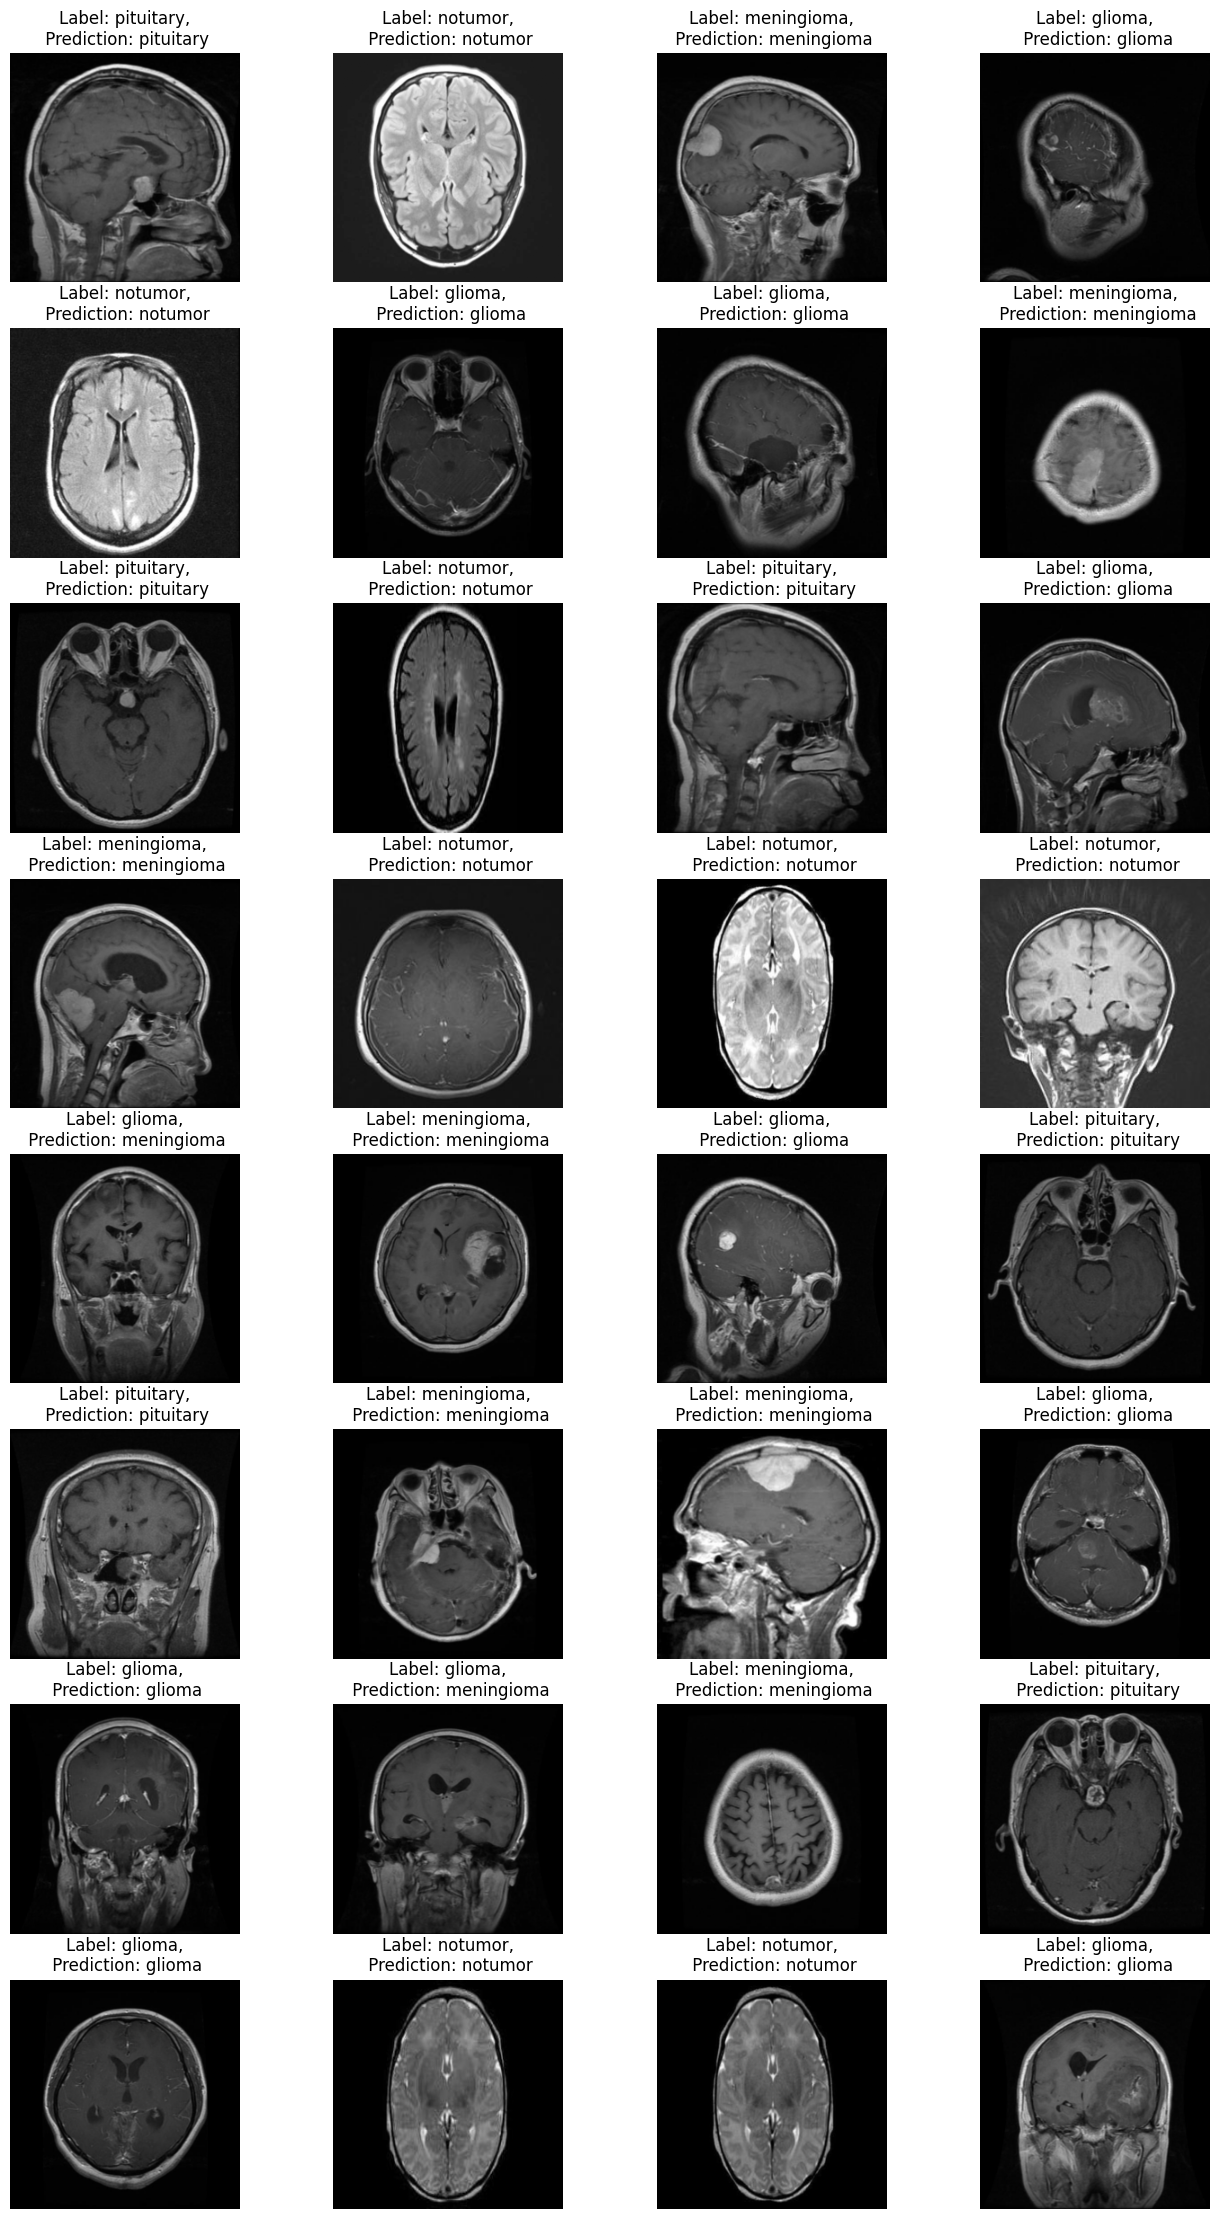

In [23]:
show_images(0)